## Time series Forecasting de US 10 YEAR BONDS usando una red neuronal LSTM y variables exógenas
Notebook para predecir el rendimiento de los bonos americanos a 10 años mediante un modelo de red neuronal LSTM (este modelo ha demostrado ser el que mejor desempeño ha tenido para la predicción de rendimientos de estos bonos con los datos sin variables exógenas, utilizando únicamente como variable de entrada los rendimientos pasados. Mirar notebook 'USbonds_Models_Forecasting'). Los datos con los que vamos a trabajar son la serie temporal diaria de rendimientos de los bonos de los EEUU a 10 años con un horizonte temporal de 14 años (desde el 2010 hasta el 2024) más las variables exógenas que representan las probabilidades de pertenencia de cada discurso a los 5 tópicos analizados en el notebook 'Modelo_LDA'

### Estructura del notebook:
1. Carga de datos y de librerías
2. Creación, entrenamiento, cálculo de predicciones, grid search y evaluación del rendimiento final del modelo LSTM para los datos de rendimientos diarios sin las variables exógenas anteriormente mencionadas
3. Unión de los datasets para generar una serie temporal con las variables de rendimientos diarios y las exógenas
4. Mismo procedimiento del apartado 2 pero con las variables explicativas adicionales 

### Librerías y carga de datos

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelado y Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap
shap.initjs()

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"Versión skforecast: {skforecast.__version__}")
print(f"Versión lightgbm: {lightgbm.__version__}")
print(f"Versión scikit-learn: {sklearn.__version__}")

Versión skforecast: 0.12.0
Versión lightgbm: 4.3.0
Versión scikit-learn: 1.5.0


#### Dataset con las variables exógenas

In [150]:
df_discursos = pd.read_csv('dataset_final.csv')

df_discursos.head()

,texto,persona,fecha,year,lemmas,topic_dominant,topic_0,topic_1,topic_2,topic_3,topic_4
0,For release on delivery 12:30 p.m. EDT ...,yellen,2015-07-10,2015,"['release', 'delivery', 'edt', 'july', 'recent...",0,0.997907,0.000092,0.001816,0.000093,0.000093
1,For release on delivery 7:15 p.m. E DT (4:15 ...,waller,2022-05-06,2022,"['release', 'delivery', 'pdt', 'reflection', '...",0,0.999300,0.000175,0.000177,0.000173,0.000175
2,For release on delivery 9:00 a.m. EST Februar...,bernanke,2012-02-16,2012,"['release', 'delivery', 'est', 'february', 'co...",4,0.000101,0.046028,0.009450,0.000100,0.944321
3,For release on delivery 9:00 a.m. E DT Octobe...,yellen,2017-10-15,2017,"['release', 'delivery', 'october', 'economy', ...",0,0.999114,0.000221,0.000222,0.000220,0.000223
4,"For release on delivery 8:00 p.m. EDT May 12, ...",bernanke,2011-05-12,2011,"['release', 'delivery', 'edt', 'remark', 'ben'...",3,0.000674,0.000679,0.000677,0.953804,0.044167


#### Dataset original

In [259]:
# Lectura de los datos de la Serie temporal del precio de los bonos americanos a 10 años

df = pd.read_csv('10-year-treasury-bond-rate-yield-chart.csv')

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.asfreq('d')
df = df.loc["2010-01-04 00:00:00":]
df = df.asfreq('d')
#Sustitumos los valores nulos por el valor inmediatamente anterior no nulo
df = df.fillna(method='ffill')

Fechas train      : 2010-01-04 00:00:00 --- 2020-01-01 00:00:00  (n=3650)
Fechas validacion : 2020-01-02 00:00:00 --- 2022-10-31 00:00:00  (n=1034)
Fechas test       : 2022-11-01 00:00:00 --- 2024-04-19 00:00:00  (n=536)


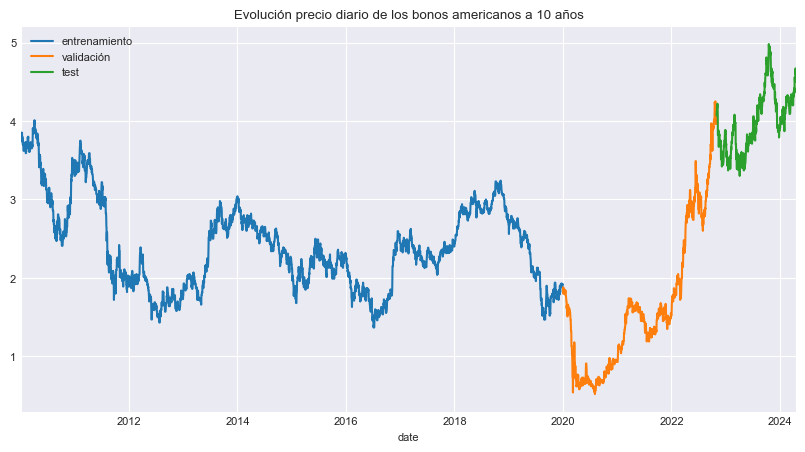

In [260]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2020-01-01 23:59:59'
fin_validacion = '2022-10-31 23:59:59'
datos_train = df.loc[: fin_train, :].copy()
datos_val   = df.loc[fin_train:fin_validacion, :].copy()
datos_test  = df.loc[fin_validacion:, :].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# Gráfico
# ======================================================================================

df_series = df.squeeze()
fig, ax = plt.subplots(figsize=(10, 5))
df_series.loc[:fin_train].plot(ax=ax, label='entrenamiento')
df_series.loc[fin_train:fin_validacion].plot(ax=ax, label='validación')
df_series.loc[fin_validacion:].plot(ax=ax, label='test')
ax.set_title('Evolución precio diario de los bonos americanos a 10 años')
ax.legend();

### Modelo de forecasting con Redes Neuronales LSTM para los datos de la serie original (sin variables exógenas)

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Error de validación (mse): 0.0006581849625816326


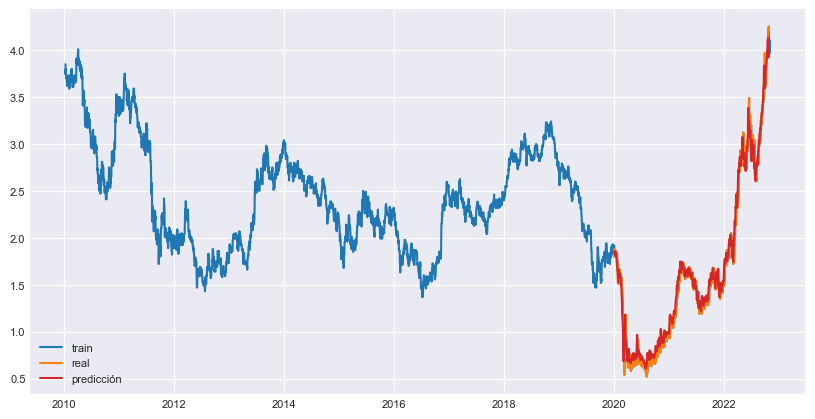

In [261]:
# Modelo de forecasting con Redes Neuronales LSTM
# Vamos a crear un modelo de forecasting de time series con un modelo no lineal de machine learning como Lstms 

# Modelo de forecasting con Lstm (Long Short Term Memory). Se trata de una red neuronal recurrente que se utiliza para predecir series temporales y que es capaz de recordar información a largo plazo.
# ==============================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor

# Escalado de los datos
# ==============================================================================
scaler = MinMaxScaler(feature_range=(0, 1))
serie_train = df.loc[:fin_train].squeeze().values.reshape(-1, 1)
serie_train_scaled = scaler.fit_transform(serie_train)

# División de los datos en secuencias
# ==============================================================================
def secuencias_entrada(secuencia, pasos):
    """ Función que divide una secuencia en múltiples secuencias más pequeñas
    """
    X, y = [], []
    for i in range(len(secuencia)):
        # índices de fin de la secuencia
        fin_seq = i + pasos
        # comprobar si nos hemos salido de la secuencia
        if fin_seq > len(secuencia)-1:
            break
        # obtener la secuencia de entrada y añadir al conjunto X
        seq_x = secuencia[i:fin_seq]
        X.append(seq_x)
        # obtener el valor que sigue a la secuencia y añadirlo a y
        seq_y = secuencia[fin_seq]
        y.append(seq_y)
    return np.array(X), np.array(y)

# Definición de la secuencia de entrada
pasos = 7
X_train, y_train = secuencias_entrada(serie_train_scaled, pasos)

# Creación del modelo
# ==============================================================================
def crear_modelo(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = KerasRegressor(dropout_rate=0.2, units= 50, build_fn=crear_modelo, verbose=0)

# Entrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Predicciones
# ==============================================================================
serie_val = datos_val.squeeze().values.reshape(-1, 1)
serie_val_scaled = scaler.transform(serie_val)

X_val, y_val = secuencias_entrada(serie_val_scaled, pasos)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.loc[:fin_validacion].index[pasos:], df.loc[:fin_validacion].values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Mejores parámetros: {'batch_size': 32, 'epochs': 100}
Mejor resultado - MSE: 0.9921712582219132


``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Error de validación (mse): 0.0007375130656940051


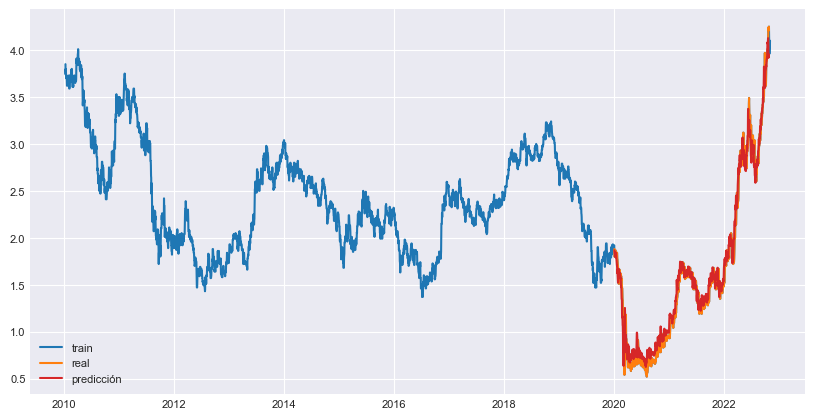

In [262]:
# Grid search de hiperparámetros LSTM
# ==============================================================================
from sklearn.model_selection import GridSearchCV


model = KerasRegressor(dropout_rate=0.2, units= 50, build_fn=crear_modelo, verbose=0)

param_grid = {'batch_size': [32, 64], 
                'epochs': [50, 100]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2) 

# Escalado de los datos
# ==============================================================================
scaler = MinMaxScaler(feature_range=(0, 1))
serie_train = datos_train.squeeze().values.reshape(-1, 1)
serie_train_scaled = scaler.fit_transform(serie_train)

# Definición de la secuencia de entrada
pasos = 7
X_train, y_train = secuencias_entrada(serie_train_scaled, pasos)

# Definición de la secuencia de entrada para los datos de validación
serie_val = datos_val.squeeze().values.reshape(-1, 1)
serie_val_scaled = scaler.transform(serie_val)
X_val, y_val = secuencias_entrada(serie_val_scaled, pasos)

# Ajuste del modelo y búsqueda de hiperparámetros
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Resultados
# ==============================================================================
print(f"Mejores parámetros: {grid_result.best_params_}") 
print(f"Mejor resultado - MSE: {grid_result.best_score_}") # Este es el MSE de los datos de entrenamiento con el mejor modelo

# Predicciones con el mejor modelo
model = grid_result.best_estimator_
model.fit(X_train, y_train, validation_data=(X_val, y_val))
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.loc[:fin_validacion].index[pasos:], df.loc[:fin_validacion].values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val.values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

Error de prueba (mse): 0.002021765894885623


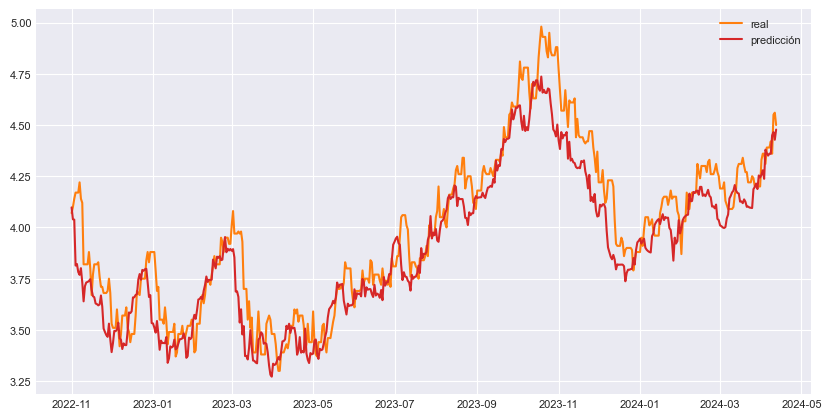

In [263]:
# Evaluación del rendimiento final del modelo LSTM (hiperparámetros ajustados) utilizando el conjunto de prueba.

# Definición de la secuencia de entrada para los datos de prueba
serie_test = datos_test.squeeze().values.reshape(-1, 1)
serie_test_scaled = scaler.transform(serie_test)
X_test, y_test = secuencias_entrada(serie_test_scaled, pasos)

# Predicciones con el mejor modelo en los datos de prueba
preds_test_scaled = model.predict(X_test)
preds_test = scaler.inverse_transform(preds_test_scaled)

# Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_test.index[:len(preds_test)], datos_test.values[:len(preds_test)], label='real', color='tab:orange')
ax.plot(datos_test.index[:len(preds_test)], preds_test, label='predicción', color='tab:red')
ax.legend();

# Error de prueba
error_test = mean_squared_error(y_test, preds_test_scaled)
print(f"Error de prueba (mse): {error_test}")

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 4684
Number of observations used for backtesting: 536
    Number of folds: 536
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-01 00:00:00 -- 2022-11-01 00:00:00  (n=1)
Fold: 1
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-02 00:00:00 -- 2022-11-02 00:00:00  (n=1)
Fold: 2
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-03 00:00:00 -- 2022-11-03 00:00:00  (n=1)
Fold: 3
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-04 00:00:00 -- 2022-11-04 00:00:00  (n=1)
Fold: 4
    Training:   2010-01-04 00:00:00 -- 2022-10-31 00:00:00  (n=4684)
    Validation: 2022-11-05 00:00:00 

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/536 [00:00<?, ?it/s]

Error de backtest (mse): 0.01726067586464614


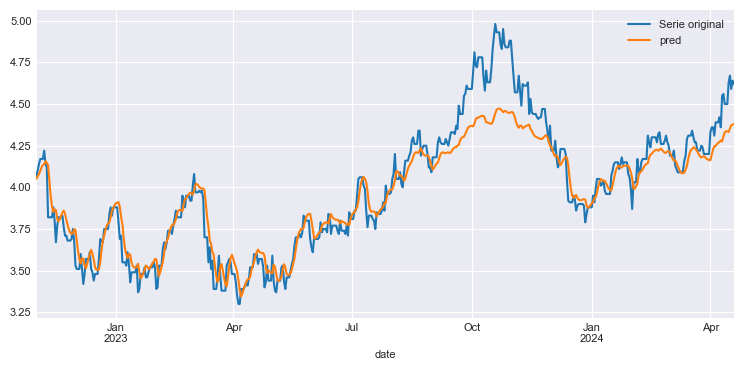

In [264]:
# Backtesting del mejor modelo LSTM
# ==============================================================================
from skforecast.model_selection import backtesting_forecaster

# Crear objeto forecaster
forecaster = ForecasterAutoreg(
                    regressor = model,
                    lags     = pasos
                )

# Backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                        forecaster = forecaster,
                                        y          = df.squeeze(),
                                        initial_train_size = len(df.loc[:fin_validacion]),
                                        steps     = 1,
                                        metric    = 'mean_squared_error',
                                        verbose   = True
                                  )

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df_test_series = datos_test.squeeze()
df_test_series.plot(ax=ax, label='Serie original')
predicciones_backtest.plot(ax=ax, label='Predicciones backtest')
ax.legend();

# Error de backtest
# ==============================================================================
print(f"Error de backtest (mse): {metrica}")

### Incorporación de variables explicativas exógenas adicionales: probabilidades de pertenencia de los discursos a cada uno de los tópicos analizados en el apartado de análisis de sentimientos

#### Unión de ambos datasets

In [265]:
df_discursos['fecha'] = pd.to_datetime(df_discursos['fecha'], format='%Y-%m-%d')

In [266]:
# Vamos a añadir al dataset de rendimientos de los bonos americanos, al que hemos llamado df, una nueva variable explicativa adicional exógena que son, para cada discurso, las probabilidades de pertenencia a cada uno de los tópicos del dataset de discursos (llamado 'df_discursos). Para ello, vamos a unir ambos datasets por la fecha de los discursos mediante un join por la fecha y para los valores nulos emplearemos alguna técnica de imputación de NAs mediante el método de forward fill.

# Unión de los datasets por la fecha
# ==============================================================================
df.reset_index(drop=False, inplace=True)
df = df.merge(df_discursos, left_on='date', right_on='fecha', how='left')

# Llenar los valores nulos con el método de forward fill
df.fillna(method='ffill', inplace=True)



In [267]:
# Eliminamos los registros (filas) que contengan algun valor nulo en alguna de las columnas
# ==============================================================================
df.dropna(inplace=True)

# Seleccionamos las columans que vamos a emplear como variables explicativas
# ==============================================================================
# Lista de columnas que quieres mantener
columnas = ['date', ' value', 'topic_0', 'topic_1',	'topic_2',	'topic_3',	'topic_4']

# Filtrar el DataFrame para solo estas columnas
df = df[columnas]


In [268]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')

Fechas train      : 2010-09-24 00:00:00 --- 2020-01-01 00:00:00  (n=3390)
Fechas validacion : 2020-01-02 00:00:00 --- 2022-10-31 00:00:00  (n=1034)
Fechas test       : 2022-11-01 00:00:00 --- 2024-04-19 00:00:00  (n=536)


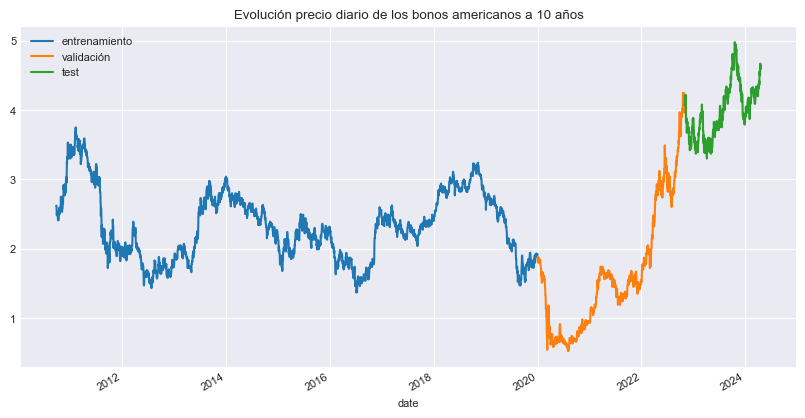

In [269]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2020-01-01 23:59:59'
fin_validacion = '2022-10-31 23:59:59'
datos_train = df.loc[: fin_train, :].copy()
datos_val   = df.loc[fin_train:fin_validacion, :].copy()
datos_test  = df.loc[fin_validacion:, :].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

# Gráfico
# ======================================================================================

df_series = df[' value'].squeeze()
fig, ax = plt.subplots(figsize=(10, 5))
df_series.loc[:fin_train].plot(ax=ax, label='entrenamiento')
df_series.loc[fin_train:fin_validacion].plot(ax=ax, label='validación')
df_series.loc[fin_validacion:].plot(ax=ax, label='test')
ax.set_title('Evolución precio diario de los bonos americanos a 10 años')
ax.legend();

### Llevamos a cabo el modelo LSTM con el nuevo dataset creado que contiene las variables adicionales exógenas de los discursos

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0433
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0163
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0106
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0063
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0038
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0026
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0021
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0019
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0017
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0017
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0015
Epoch 12/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0015
Epoch 13/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0015
Epoch 14/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0014
Epoch 15/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/ste

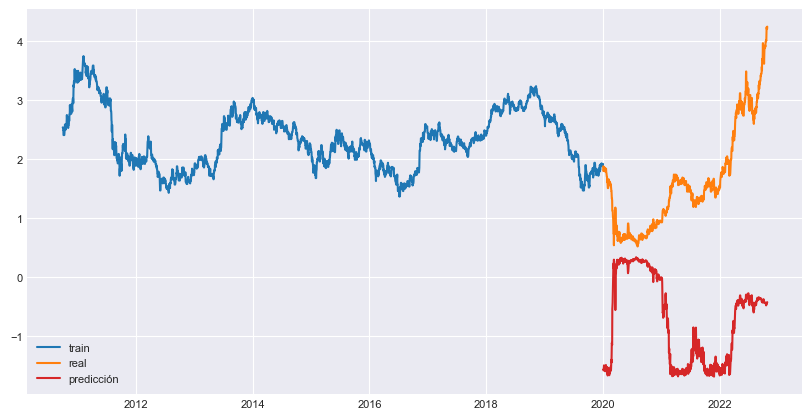

In [278]:
# Llevamos a cabo el modelo LSTM con el nuevo dataset creado (df) que contiene las variables exógenas de los discursos adicionales
# ==============================================================================
# Escalado de datos
# ==============================================================================
scaler = MinMaxScaler(feature_range=(0, 1))
serie_train = df.loc[:fin_train].squeeze().values.reshape(-1, 1)
serie_train_scaled = scaler.fit_transform(serie_train)

# División de los datos en secuencias
# ==============================================================================
def secuencias_entrada(secuencia, pasos):
    """ Función que divide una secuencia en múltiples secuencias más pequeñas
    """
    X, y = [], []
    for i in range(len(secuencia)):
        # índices de fin de la secuencia
        fin_seq = i + pasos
        # comprobar si nos hemos salido de la secuencia
        if fin_seq > len(secuencia)-1:
            break
        # obtener la secuencia de entrada y añadir al conjunto X
        seq_x = secuencia[i:fin_seq]
        X.append(seq_x)
        # obtener el valor que sigue a la secuencia y añadirlo a y
        seq_y = secuencia[fin_seq]
        y.append(seq_y)
    return np.array(X), np.array(y)

# Definición de la secuencia de entrada
pasos = 7
X_train, y_train = secuencias_entrada(serie_train_scaled, pasos)

# Creación del modelo
# ==============================================================================
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
# ==============================================================================
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Predicciones
# ==============================================================================
serie_val = datos_val[' value'].squeeze().values.reshape(-1, 1)
serie_val_scaled = scaler.transform(serie_val)

X_val, y_val = secuencias_entrada(serie_val_scaled, pasos)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_train.index[pasos:], datos_train[' value'].values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val[' value'].values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
# ==============================================================================
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Mejores parámetros: {'batch_size': 32, 'epochs': 100}
Mejor resultado - MSE: 0.9919629329482023


``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Error de validación (mse): 0.5318689639699578


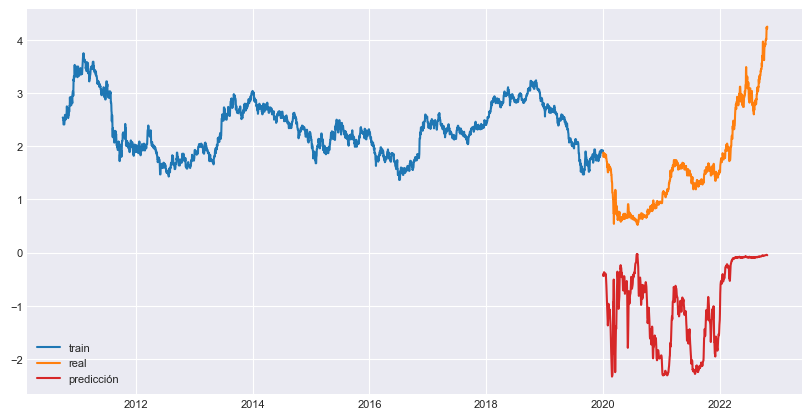

In [271]:
# Búsqueda de hiperparámetros LSTM
# ==============================================================================
from sklearn.model_selection import GridSearchCV
def crear_modelo(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
model = KerasRegressor(dropout_rate=0.2, units= 50, build_fn=crear_modelo, verbose=0)

param_grid = {'batch_size': [32, 64],
                'epochs': [50, 100]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Ajuste del modelo y búsqueda de hiperparámetros
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Resultados
# ==============================================================================
print(f"Mejores parámetros: {grid_result.best_params_}")
print(f"Mejor resultado - MSE: {grid_result.best_score_}")

# Predicciones con el mejor modelo
model = grid_result.best_estimator_
model.fit(X_train, y_train, validation_data=(X_val, y_val))
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
preds_scaled = model.predict(X_val)
preds = scaler.inverse_transform(preds_scaled)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_train.index[pasos:], datos_train[' value'].values[pasos:], label='train', color='tab:blue')
ax.plot(datos_val.index[:len(preds)], datos_val[' value'].values[:len(preds)], label='real', color='tab:orange')
ax.plot(datos_val.index[:len(preds)], preds, label='predicción', color='tab:red')
ax.legend();

# Error de validación
# ==============================================================================
error = mean_squared_error(y_val, preds_scaled)
print(f"Error de validación (mse): {error}")

Error de prueba (mse): 1.1687549321993174


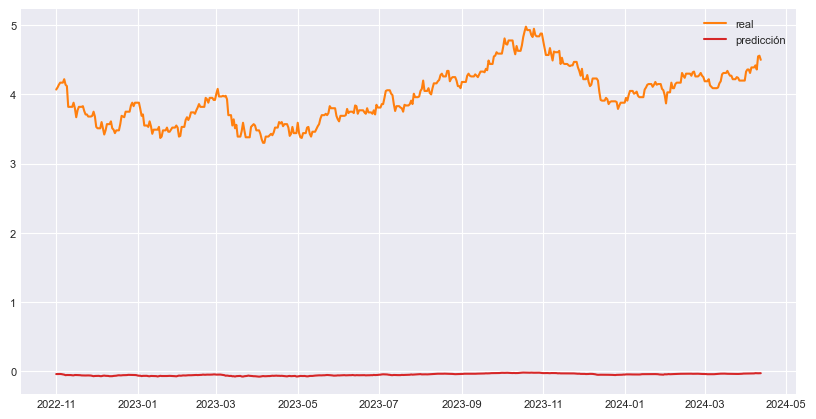

In [272]:
# Evaluación del rendimiento final del modelo LSTM (hiperparámetros ajustados) con las variables exógenas utilizando el conjunto de prueba.
# ==============================================================================
serie_test = datos_test[' value'].squeeze().values.reshape(-1, 1)
serie_test_scaled = scaler.transform(serie_test)
X_test, y_test = secuencias_entrada(serie_test_scaled, pasos)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predicciones con el mejor modelo en los datos de prueba
preds_test_scaled = model.predict(X_test)
preds_test = scaler.inverse_transform(preds_test_scaled)


# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(datos_test.index[:len(preds_test)], datos_test[' value'].values[:len(preds_test)], label='real', color='tab:orange')
ax.plot(datos_test.index[:len(preds_test)], preds_test, label='predicción', color='tab:red')
ax.legend();

# Error de prueba
# ==============================================================================
error_test = mean_squared_error(y_test, preds_test_scaled)
print(f"Error de prueba (mse): {error_test}")

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Information of backtesting process
----------------------------------
Number of observations used for initial training: 4421
Number of observations used for backtesting: 536
    Number of folds: 536
    Number of steps per fold: 1
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-09-24 00:00:00 -- 2022-10-31 00:00:00  (n=4421)
    Validation: 2022-11-01 00:00:00 -- 2022-11-01 00:00:00  (n=1)
Fold: 1
    Training:   2010-09-24 00:00:00 -- 2022-10-31 00:00:00  (n=4421)
    Validation: 2022-11-02 00:00:00 -- 2022-11-02 00:00:00  (n=1)
Fold: 2
    Training:   2010-09-24 00:00:00 -- 2022-10-31 00:00:00  (n=4421)
    Validation: 2022-11-03 00:00:00 -- 2022-11-03 00:00:00  (n=1)
Fold: 3
    Training:   2010-09-24 00:00:00 -- 2022-10-31 00:00:00  (n=4421)
    Validation: 2022-11-04 00:00:00 -- 2022-11-04 00:00:00  (n=1)
Fold: 4
    Training:   2010-09-24 00:00:00 -- 2022-10-31 00:00:00  (n=4421)
    Validation: 2022-11-05 00:00:00 

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.


  0%|          | 0/536 [00:00<?, ?it/s]

Error de backtest (mse): 0.016021982295164248


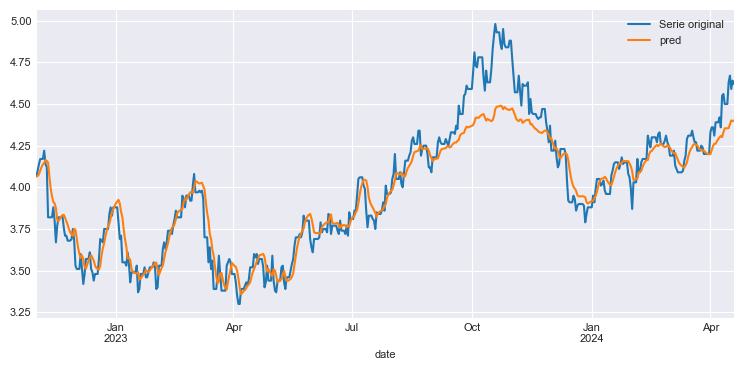

In [288]:
# Backtesting del mejor modelo con variables explicativas adicionales
# ==============================================================================
df = df.groupby(df.index).mean().asfreq('d')

# Crear objeto forecaster
forecaster = ForecasterAutoreg(
                    regressor = grid_result.best_estimator_,
                    lags     = pasos
                )

# Backtest
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = df[' value'].squeeze(),
                                    exog       = df.iloc[:, 1:], # Especificamos las variables exógenas a utilizar en el backtest
                                    initial_train_size = len(df.loc[:fin_validacion]),
                                    steps     = 1,
                                    metric    = 'mean_squared_error',
                                    verbose   = True
                                )

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df_test_series = datos_test[' value'].squeeze()
df_test_series.plot(ax=ax, label='Serie original')
predicciones_backtest.plot(ax=ax, label='Predicciones backtest')
ax.legend();

# Error de backtest
# ==============================================================================
print(f"Error de backtest (mse): {metrica}")


